# Coarse Grained Monte Carlo (MC) Simulations For Osmotic Second Virial Coefficient Calculations

# Purpose

The purpose of this notebook is to perform Metropolis Monte Carlo simulations able to catch protein-protein interactions in salt solutions. In particular, using Faunus, we can sample the radial distribution function, $g(r)$ and then we calculate the osmotic second virial coefficient, $B_{2}$, of two identical interacting proteins for different solution conditions (salt and pH).

# Steps

1. Coarse-graining of the initial structure
2. Functions
3. Model
4. Simulations
5. Analysis 

# Let's begin!

## Import packages 

In [3]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import json
import os
from scipy.optimize import curve_fit
from os import chdir, getcwd
from IPython.display import display, HTML
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update("rise", {"theme": "sky",'width': '100%','height': '100%', "auto_select": "code"})

{'theme': 'sky',
 'transition': 'zoom',
 'start_slideshow_at': 'selected',
 'width': '100%',
 'height': '100%',
 'auto_select': 'code',
 'auto_select_fragment': True}

# Let's start coarse-graining the initial structure

This part of the code loads a pdb from the Protein Data Bank https://www.rcsb.org/pdb/home/home.do and coarse grain it at amino acid level (each amino acid is replaced by a sphere) and gives as output a input.pqr file that is used to perform the simulations.
<center><img src='CG2.png' style="width:800px alt="Drawing ></center>


In [7]:
######################### Select a working directory #########################
workdir = '/Users/michael/Desktop/Courses/Introduction_To_Python/project'
chdir(workdir)
##############################################################################

################## Download the initial all-atom pdb structure ##############
pdb = md.load_pdb('https://files.rcsb.org/view/1ZFU.pdb')
##############################################################################

####################### Count residues and Select protein ###################
res_number = pdb.n_residues #
protein = pdb.topology.select('protein') 
topology = pdb.topology.subset(protein) 
##############################################################################

####################### Coarse graining ###################
f = open('input.pqr','w')
f.write(str(res_number)+'\n')

for res in topology.residues:
    cm = [0,0,0] # residue mass center
    mw = 0       # residue weight
    for i in res.atoms:
        cm = cm + i.element.mass * pdb.xyz[0][i.index]
        mw = mw + i.element.mass
    cm = cm/mw*10
    radius = ( 3./(4*np.pi)*mw/1.0 )**(1/3.)
    f.write('{0:6} {1:4} {2:4} {3:4} {4:5} {5:11.3f} {6:8.3f} {7:8.3f} {8:8.3f} {9:6.3f}\n'\
        .format('ATOM',res.index,res.name,res.name, 0 , cm[0],cm[1],cm[2],0, radius))
f.write('END')
f.close()
print('Coarse-grained file created')

Coarse-grained file created


# Before the simulation we extrapolate salt activity coefficients

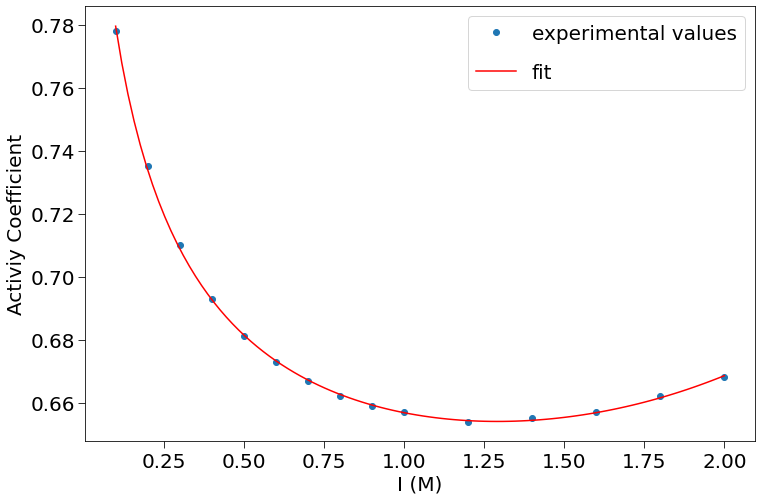

In [7]:
plt.rcParams.update({'font.size':20,'legend.frameon':True,'figure.figsize':[12,8],
              'xtick.major.size':7,'ytick.major.size':7,'legend.labelspacing':1})

# This part of the code extrapolate the experimental NaCl activity coefficients in the range 0.1 - 2.0 M.
# The date are taken from: https://pubs.rsc.org/en/content/articlehtml/1949/tf/tf9494500612

conc_range = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
gamma_exp = np.array([0.778, 0.735, 0.71, 0.693, 0.681, 0.673, 0.667, 0.662, 0.659, 0.657, 0.654, 0.655, 0.657, 0.662, 0.668])

################################## Fitting function #############################
def func(x, a, b, c, d):                                                        #
     return np.exp(a*x + b*np.sqrt(x) + c * np.power(x,3/2) + d * np.power(x,2))#
#################################################################################

popt, pcov = curve_fit(func, conc_range, gamma_exp)    

x_min = 0.1  
x_max = 2.0                                #min/max values for x axis
x_fit = np.linspace(x_min, x_max, 100)     #range of x values used for the fit function
plt.plot(conc_range, gamma_exp, 'o', label='experimental values')
plt.plot(x_fit, func(x_fit, *popt),'r', label='fit')
plt.xlabel('I (M)')
plt.ylabel('Activiy Coefficient')
plt.legend()
plt.show()

#############################################################################

# Function to extract activity coefficients

def Activity_Coeff(salt):
     return np.exp(popt[0]*salt + popt[1]*np.sqrt(salt) + popt[2]*np.power(salt,3/2) 
                   + popt[3]*np.power(salt,2))

## Model and theory

The model consists of two proteins (in this case identical) in a cylindrical space, modeled as a collection of beads (each representing one amino acid).

<center><img src='Model.png' style="width:800px alt="Drawing ></center>
The proteins are allowed to translate along the z-axis and rotate around their center of mass. The protonation states of each amino acid can also change according to the pH. Implicit salt and solvent are used. In these simulations, we sample the radial distribution function, $g(r)$, which gives the probability of finding a protein at a separation $r$ from the other, compared to the ideal gas distribution. From $g(r)$ we can calculate the potential of the mean force as PMF = -log(g(r)), and the so-called osmotic second virial coefficient $B_{2}$, which is a measure of colloidal stability in solution. It is defined as:

\begin{equation}
B_{2}=-2\pi \int_{0}^{\infty} (g(r)-1)r_{12}^{2}dr_{12},
\end{equation}

A $B_{2}$ < 0 indicates attraction, while a $B_{2}$ > indicates repulsions between them.

# Running the simulations

## Input for Faunus

Model details as parameters, size of the simulation box and the number of steps to be performed, can be changed in this part of the code. A json file containing all these parameters will be created as input for Faunus (the Monte Carlo code).

In [ ]:
workdir = '/Users/michael/Desktop/Courses/Introduction_To_Python/project'
chdir(workdir)


#####################################################################
def debye(conc):
    ''' Convert salt concentration (in M) to Debye lenght. 
        Valid at room temperature (25 °C) for 1:1 electrolytes.'''
    return 3.04/np.sqrt(conc)
####################################################################

    
def mkinput():
    js = { "temperature": 298.15,
              "geometry": {"type":"cylinder",  "radius": radius, "length":length},  

                "mcloop": {"macro": macro, "micro": micro},
                "random": {"seed": "hardware"},

                "energy": [{"nonbonded_coulomblj":{ 
                                   "lennardjones": {"mixing": "LB"},
                                        "coulomb": {"type": "poisson", "C":1, "D": -1, "debyelength": debye(salt), "epsr": 78.7,"cutoff": 3*debye(salt)}}}],
          
              "atomlist": [
                ###################
                #### TERMINALS ####
                ###################
                {"CTR": {"mw": 16.0,"sigma": 3.13,"eps": eps,"q": -1}},
                {"HCTR": {"mw": 16.0,"sigma": 3.13,"eps": eps,"q": 0}},
                {"NTR": {"mw": 14.0,"sigma": 2.99,"eps": eps,"q": 0}},
                {"HNTR": {"mw": 14.0,"sigma": 2.99,"eps": eps,"q": 1}},
                 #{"CLHNTR": {"mw": 14.0,"sigma": 2.99,"eps": eps,"q": 0}},
                ###################
                ####Hydrophobic####
                ###################
                {"ALA": {"mw": 66.0,"sigma": 5.02,"eps": eps,"q": 0}},
                {"ILE": {"mw": 102.0,"sigma": 5.8,"eps": eps,"q": 0}},
                {"LEU": {"mw": 102.0,"sigma": 5.8,"eps": eps,"q": 0}},
                {"MET": {"mw": 122.0,"sigma": 6.16,"eps": eps,"q": 0}},
                {"PHE": {"mw": 138.0,"sigma": 6.41,"eps": eps,"q": 0}},
                {"VAL": {"mw": 90.0,"sigma": 5.56,"eps": eps,"q": 0}},
                {"PRO": {"mw": 90.0,"sigma": 5.56,"eps": eps,"q": 0}},
                {"GLY": {"mw": 54.0,"sigma": 4.69,"eps": eps,"q": 0}},
                #########################
                #### Not Hydrophobic ####
                #########################  
                {"ARG": {"mw": 144.0,"sigma": 6.50,"eps": eps,"q": 0}},
                {"HARG": {"mw": 144.0,"sigma": 6.50,"eps": eps,"q": 1}},
                {"LYS": {"mw": 116.0,"sigma": 6.05,"eps": eps,"q": 0}},
                {"HLYS": {"mw": 116.0,"sigma": 6.05,"eps": eps,"q": 1}},
                {"ASP": {"mw": 110.0,"sigma": 5.94,"eps": eps,"q": -1}},
                {"HASP": {"mw": 110.0,"sigma": 5.94,"eps": eps,"q": 0}},
                {"LASP": {"mw": 110.0,"sigma": 5.94,"eps": eps,"q": 2}},
                {"GLU": {"mw": 122.0,"sigma": 6.16,"eps": eps,"q": -1}},
                {"HGLU": {"mw": 122.0,"sigma": 6.16,"eps": eps,"q": 0}},
                {"LGLU": {"mw": 122.0,"sigma": 6.16,"eps": eps,"q": 2}},
                {"GLN": {"mw": 120.0,"sigma": 6.12,"eps": eps,"q": 0}},
                {"ASN": {"mw": 108.0,"sigma": 5.91,"eps": eps,"q": 0}},
                {"HIS": {"mw": 130.0,"sigma": 6.29,"eps": eps,"q": 0}},
                {"HHIS": {"mw": 130.0,"sigma": 6.29,"eps": eps,"q": 1}},
                {"SER": {"mw": 82.0,"sigma": 5.39,"eps": eps,"q": 0}},
                {"THR": {"mw": 94.0,"sigma": 5.64,"eps": eps,"q": 0}},
                {"TYR": {"mw": 154.0, "sigma": 6.65,"eps": eps, "q": -1}},
                {"HTYR": {"mw": 154.0,"sigma": 6.65,"eps": eps,"q": 0}},
                {"CYS": {"mw": 103.0,"sigma": 5.72,"eps": eps,"q": -1}},
                {"HCYS":{"mw": 103.0,"sigma": 5.72,"eps": eps,"q": 0}},
                {"CYX": {"mw": 103.0,"sigma": 5.72,"eps": eps,"q": 0}},
                {"TRP": {"mw": 176.0,"sigma": 6.95,"eps": eps,"q": 0}},
                {"H": { "pactivity": pH, "implicit": True } }
                    ],
       
          "moleculelist": [{"protein1": {"structure": Input, "rigid":False, "insdir":[0,0,0]}},
                           {"protein2": {"structure": Input, "rigid":False, "insdir":[0,0,0], "insoffset":[0,0,50]}}
                          ],
          
          "insertmolecules": [{"protein1": {"N": 1, "inactive": False }},
                              {"protein2": {"N": 1, "inactive": False }},
                             ],
          

          
          "moves":[{"rcmc": {"repeat":1}},
                  {"moltransrot": {"molecule": "protein1", "dir":[0,0,0], "dprot":1, "dp":0,  "repeat": 1}},
                  {"moltransrot": {"molecule": "protein2", "dir":[0,0,1], "dprot":1, "dp":20,  "repeat": 1}},
                  
                  ],
             
            "reactionlist": [
            {"HCTR  = CTR + H": {"pK": 3.67} },
            {"HASP  = ASP + H": {"pK": 3.67} },
            {"HGLU  = GLU + H": {"pK": 4.25} },
            {"HHIS  = HIS + H": {"pK": 6.54} },
            {"HCYS = CYS + H": {"pK": 8.55} },  
            {"HNTR = NTR + H": {"pK": 8.0} },
            {"HARG = ARG + H": {"pK": 12.0} },    
            {"HLYS  = LYS + H": {"pK": 10.4} },
            {"HTYR = TYR + H": {"pK": 9.84} },
            ],    

            "analysis": [
            {"density": { "nstep": 1000, "nskip": nskip} }, # average concentration of molecules in moleculelist in out.json
            {"multipole": {"nstep": 1000, "nskip": nskip} }, # average charge of protein in out.json
            {"savestate": {"file": "state.json"} },  
            {"savestate": {"file": "confout.pqr"} },
            {"xtcfile": {"file": "traj.xtc", "nstep": 1000, "nskip": nskip} },
            {"systemenergy": {"file": "energy.dat", "nstep": 1000} }, 
            {"reactioncoordinate": {"file": "Q_total.dat", "nstep": 1000, "type": "system", "property": "Q"}}, # Total charge as a function of the number of steps
            {"molrdf": {"file":"rdf.dat","name1": "protein1", "name2": "protein2", "nstep": 1, "dr": 0.1, "dim": 1, "nskip": nskip}}, # Total charge as a function of the number of steps
            ######################################################################################################################################
            ]} 

    with open('input.json', 'w') as f:
        json.dump(js, f, indent=4)

        
        
########################################## Input Parameters #################################

proteins = {'runs': {'salt': [0.010, 0.140], 'pH': [4, 5, 6], 'input':workdir+'/input.aam'}}

Input = workdir+'/input.aam'

# Box
radius = 30
length = 150

#LJ parameters                                                                                                                                                                                                                                                                            
eps = 0.12395 # epsilon in kJ/mol in general equal to 0.05 kT 
       
    
# Steps                                                                                                         
micro = 1000000
macro = 5
nskip = 1000
##############################################################################################

for name, prop in proteins.items():
    os.makedirs(str(name), exist_ok=True)
    chdir(str(name))
    for salt in prop ['salt']:
        os.makedirs(str(salt), exist_ok=True)
        chdir(str(salt))
        for pH in prop['pH']:
            os.makedirs(str(pH), exist_ok=True)
            chdir(str(pH))
            print(prop['input'])
            mkinput()
            exists = os.path.isfile('state.json')
            if exists:
                !export OMP_NUM_THREADS=2;faunus -i input.json -s state.json  #> out
            else:

                !export OMP_NUM_THREADS=2;faunus -i input.json #> out
            chdir('../')   
        chdir('../')  
    chdir('../')  
chdir('../')  


/Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 25506] I: Reading molecule configuration from file: /Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 25506] W: radius mismatch on atom 0 GLY: using atomlist value
[faunus 25506] W: radius mismatch on atom 1 PHE: using atomlist value
[faunus 25506] W: radius mismatch on atom 2 GLY: using atomlist value
[faunus 25506] W: charge mismatch on atom 3 CYS: ignoring atomlist value
[faunus 25506] W: radius mismatch on atom 3 CYS: using atomlist value
[faunus 25506] W: radius mismatch on atom 4 ASN: using atomlist value
[faunus 25506] W: radius mismatch on atom 5 GLY: using atomlist value
[faunus 25506] W: radius mismatch on atom 6 PRO: using atomlist value
[faunus 25506] W: radius mismatch on atom 7 TRP: using atomlist value
[faunus 25506] W: charge mismatch on atom 8 ASP: ignoring atomlist value
[faunus 25506] W: radius mismatch on atom 8 ASP: using atomlist value
[faunus 25506] W: ch

[============================================================] 100% 1168.1/1168.1s
[faunus 25506] I: relative drift = 2.46711e-14
/Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 26047] I: Reading molecule configuration from file: /Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 26047] W: radius mismatch on atom 0 GLY: using atomlist value
[faunus 26047] W: radius mismatch on atom 1 PHE: using atomlist value
[faunus 26047] W: radius mismatch on atom 2 GLY: using atomlist value
[faunus 26047] W: charge mismatch on atom 3 CYS: ignoring atomlist value
[faunus 26047] W: radius mismatch on atom 3 CYS: using atomlist value
[faunus 26047] W: radius mismatch on atom 4 ASN: using atomlist value
[faunus 26047] W: radius mismatch on atom 5 GLY: using atomlist value
[faunus 26047] W: radius mismatch on atom 6 PRO: using atomlist value
[faunus 26047] W: radius mismatch on atom 7 TRP: using atomlist value
[faunus 26047] W: charge mismatch

[============================================================] 100% 1157.6/1157.6s
[faunus 26047] I: relative drift = -3.69166e-14
/Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 26483] I: Reading molecule configuration from file: /Users/michael/Desktop/Courses/Introduction_To_Python/project/input.aam
[faunus 26483] W: radius mismatch on atom 0 GLY: using atomlist value
[faunus 26483] W: radius mismatch on atom 1 PHE: using atomlist value
[faunus 26483] W: radius mismatch on atom 2 GLY: using atomlist value
[faunus 26483] W: charge mismatch on atom 3 CYS: ignoring atomlist value
[faunus 26483] W: radius mismatch on atom 3 CYS: using atomlist value
[faunus 26483] W: radius mismatch on atom 4 ASN: using atomlist value
[faunus 26483] W: radius mismatch on atom 5 GLY: using atomlist value
[faunus 26483] W: radius mismatch on atom 6 PRO: using atomlist value
[faunus 26483] W: radius mismatch on atom 7 TRP: using atomlist value
[faunus 26483] W: charge mismatc

# Analysis

### Energy check

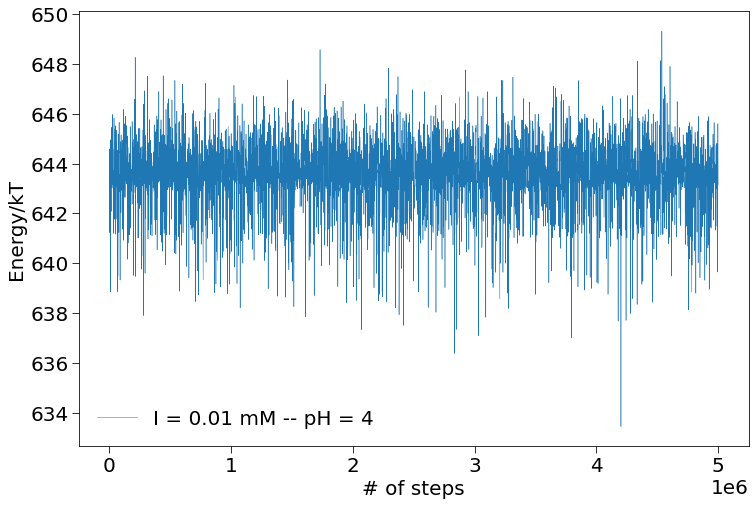

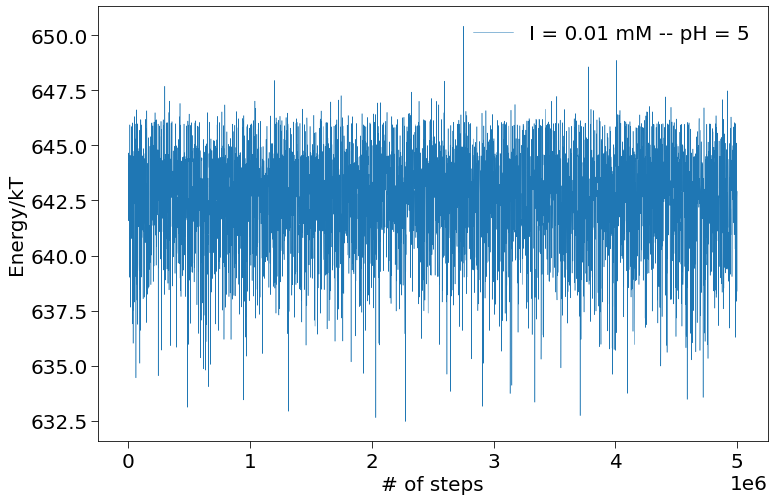

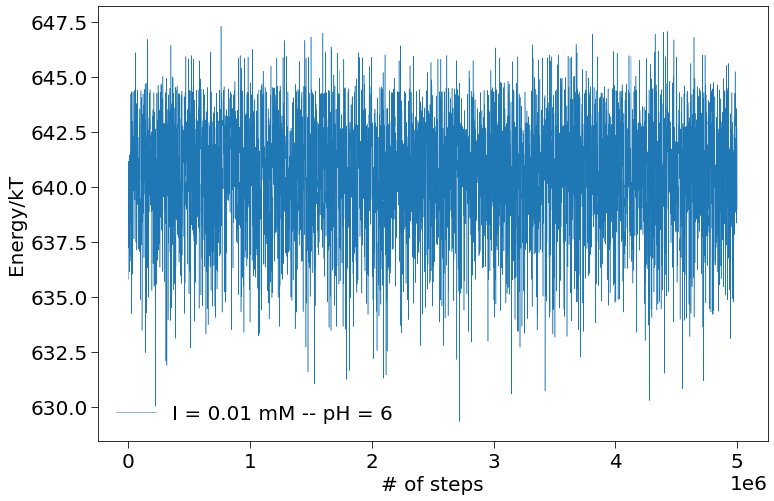

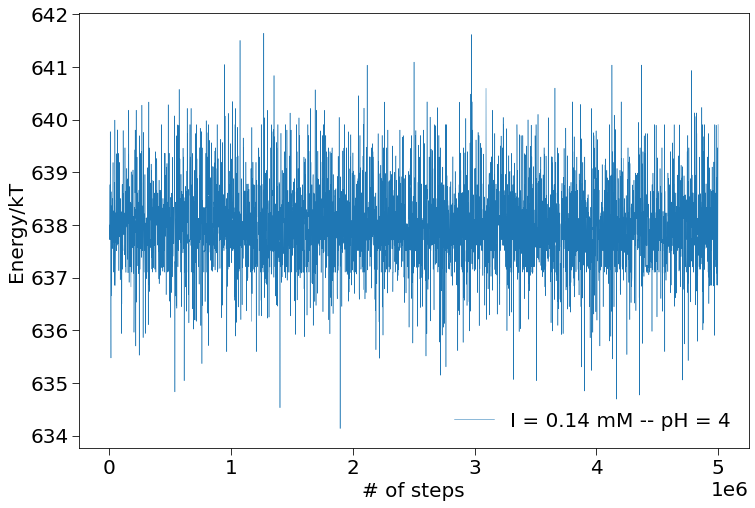

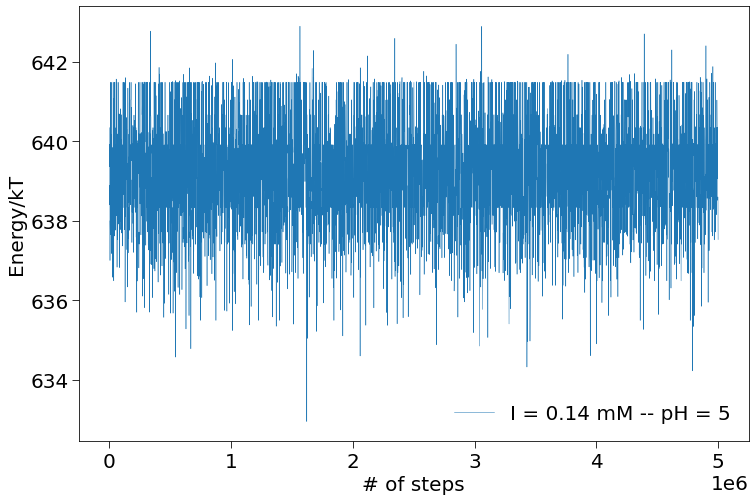

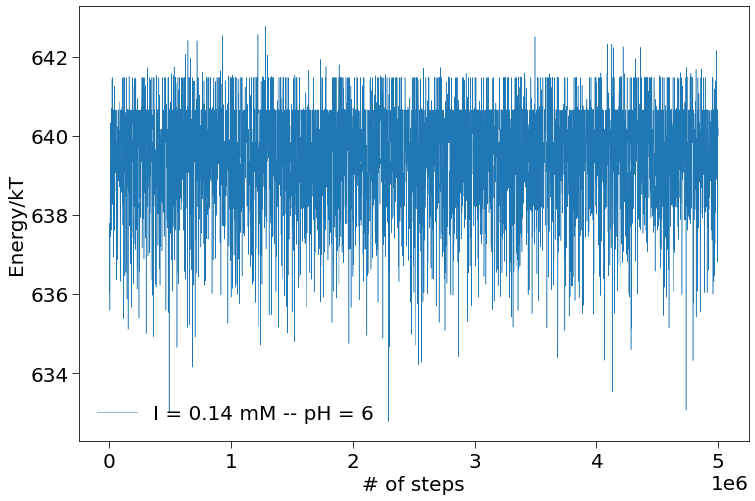

In [28]:
workdir = '/Users/michael/Desktop/Courses/Introduction_To_Python/project'
chdir(workdir)

###############################################################
proteins = {'runs': {'salt': [0.010, 0.140], 'pH': [4, 5, 6]}}#
Mw=4400                                                       #
###############################################################

for name, prop in proteins.items():
    chdir(str(name))
    for salt in prop ['salt']:
        chdir(str(salt))
        for pH in prop['pH']:
            chdir(str(pH))
            x1, y1 = np.loadtxt('Energy.dat',unpack=True, usecols=(0,1))
            plt.plot(x1, y1, '-', label='I = '+str(salt)+' mM -- '+'pH = '+str(pH), lw=0.5 )
            plt.xlabel('# of steps')
            plt.ylabel('Energy/kT')
            plt.legend(frameon=False, loc=0)
            plt.show()
            chdir('../')   
        chdir('../')  
    chdir('../')  
chdir('../')  



## PMF and $B_2$

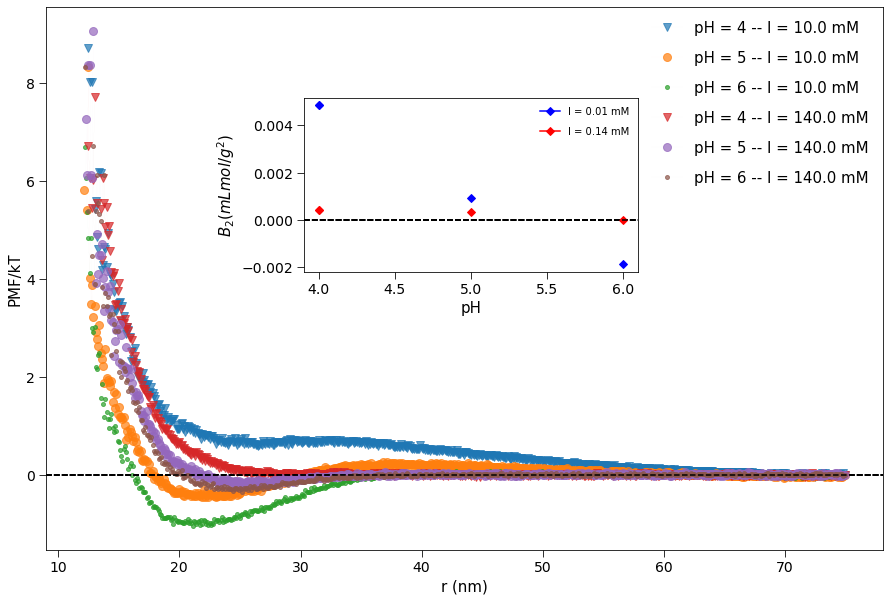

In [5]:
workdir = '/Users/michael/Desktop/Courses/Introduction_To_Python/project'
chdir(workdir)

###############################################################
proteins = {'runs': {'salt': [0.010, 0.140], 'pH': [4, 5, 6]}}#
Mw=4400                                                       #
###############################################################

fig, ax = plt.subplots(1, figsize=[15, 10])
axins_1 = inset_axes(ax, width="40%", height="40%", bbox_to_anchor=(.30, .50, 1, .80), bbox_transform=ax.transAxes, loc=3)#pos and size
colors = ['b', 'r']
markers = ['v', 'o', '.']

for name, prop in proteins.items():
    for c, salt in enumerate(prop ['salt']):
        for m, pH in enumerate(prop['pH']):
            path = str(name)+'/'+str(salt)+'/'+str(pH)+'/'+'rdf.dat'
            x1, y1 = np.loadtxt(path,unpack=True)
            np.seterr(divide = 'ignore')
            pmf=-np.log(y1/y1[-1])
            
            ax.plot(x1, pmf, marker=markers[m], markersize=8, label='pH = '+str(pH)+' -- I = '+str(salt*1000)+' mM', alpha=0.7, lw=0.01)
            
            ax.axhline(y=0, color='k', linestyle='--')
            ax.set_xlabel('r (nm)', fontsize=15)
            ax.set_ylabel('PMF/kT', fontsize=15)
            ax.legend(frameon=False, fontsize=15)
            
            ################################## B2 ###################################
            B2=-2*np.pi*np.trapz(np.expm1(-pmf)*x1**2, x1)*6.022e23*1e-24/Mw/Mw
            axins_1.plot(pH, B2, colors[c], marker='D')
            
            if salt == 0.010 and pH == 4:
                axins_1.plot(pH, B2, colors[c], marker='D', label='I = '+str(salt)+' mM')
                axins_1.legend(frameon=False, fontsize=10)
            
            if salt == 0.140 and pH == 4:
                axins_1.plot(pH, B2, colors[c], marker='D', label='I = '+str(salt)+' mM')
                axins_1.legend(frameon=False, fontsize=10)
            
            axins_1.set_xlabel('pH', fontsize=15)
            axins_1.set_ylabel("$B_{2} (mL mol/g^{2}$)", fontsize=15)
            axins_1.axhline(y=0, color='k', linestyle='--')